#  CNN Midi Drum Classifier

## Requirements
Have to be run in a python 3.11 env

In [133]:
#importing packages
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import os
import subprocess

# Picking out genres from dataset

Same code as in drumclassifier.ipynb

In [134]:

base_dir = './data'

# Define the genres you are interested in
genres = ['latin',  'jazz',  'punk', 'afrobeat', 'hiphop', 'soul', 'funk', 'rock', 'country', 'reggae']
# genres = ['jazz', 'rock']


# Function to check if the file genre is one of the target genres
def is_target_genre(filename):
    for genre in genres:
        if genre.replace('_', '-') in filename.lower():
            return True
    return False

# Collect all MIDI files that match the target genres
target_files = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.mid') and is_target_genre(file):
            full_path = os.path.join(root, file)
            target_files.append(full_path)

print(f"Found {len(target_files)} files in target genres.")
print(target_files[:10])

# Didnt actually end up using this, but I am keeping to code for later maybe
# Writing the paths to a text file for record-keeping or further processing
# with open('filtered_midi_files.txt', 'w') as f:
#     for item in target_files:
#         f.write("%s\n" % item)




Found 1025 files in target genres.
['./data/drummer8/session2/12_funk_81_beat_4-4.mid', './data/drummer8/session2/25_latin_84_beat_4-4.mid', './data/drummer8/session2/2_funk_92_beat_4-4.mid', './data/drummer8/session2/40_rock-indie_104_beat_4-4.mid', './data/drummer8/session2/33_rock_117_beat_4-4.mid', './data/drummer8/session2/30_afrobeat_98_beat_4-4.mid', './data/drummer8/session2/39_rock-indie_104_beat_4-4.mid', './data/drummer8/session2/14_afrobeat_103_beat_4-4.mid', './data/drummer8/session2/17_afrobeat_85_beat_4-4.mid', './data/drummer8/session2/31_afrobeat_98_beat_4-4.mid']


# Preprocsessing midi data
Same code as in drumclassifier.ipynb

In [135]:
import mido

filepath_1 = target_files[100] 
print(filepath_1)
def process_drum_track_mido(filepath):
    # Loading the MIDI file
    mid = mido.MidiFile(filepath)
    
    for i, track in enumerate(mid.tracks):
        print(f"Track {i}: {track.name}")
        for msg in track:
            if not msg.is_meta and msg.type in ['note_on', 'note_off']:
                # Seems channel 9 i correct (dont think im missing anything here?)
                # The data set says control changes are set on channel 0, but i get no data here?
                if msg.channel == 9:
                    print(f"Time: {msg.time}, Note: {msg.note}, Velocity: {msg.velocity}, Type: {msg.type}")
                    
# Example usage
# process_drum_track_mido(filepath_1)


./data/drummer1/session3/5_jazz-linear_128_beat_4-4.mid


# Extract features
Same code as in drumclassifier.ipynb

In [136]:
import mido
import numpy as np

# This gets turned into 0,1,2,3...21 in the matrix (showed in Example Usage)
relevant_notes = [36, 38, 40, 37, 48, 50, 45, 47, 43, 58, 46, 26, 42, 22, 44, 49, 55, 57, 52, 51, 59, 53]
bins_per_beat = 4
bars = 2
beats_per_bar = 4
total_beats = bars * beats_per_bar
total_bins_per_segment = total_beats * bins_per_beat

def midi_file_to_segments(filepath, bins_per_beat=4, bars_per_segment=2):
    """
    Segment a MIDI file into multiple fixed-length segments.

    Args:
        filepath (str): Path to the MIDI file.
        bins_per_beat (int): Number of bins per beat for quantization.
        bars_per_segment (int): Number of bars to include in each segment.

    Returns:
        List of np.ndarray: A list of 2D numpy arrays, each representing a segment.
    """
    mid = mido.MidiFile(filepath)

    note_indices = {note: i for i, note in enumerate(relevant_notes)}

    segments = []
    # Calculate bins and ticks for segmentation
    beats_per_bar = 4
    total_beats_per_segment = bars_per_segment * beats_per_bar
    total_bins_per_segment = total_beats_per_segment * bins_per_beat
    ticks_per_bin = mid.ticks_per_beat // bins_per_beat

    current_segment_start_tick = 0
    segment_feature_matrix = np.zeros((len(relevant_notes), total_bins_per_segment))
    current_bin_index = 0

    for track in mid.tracks:
        current_tick = 0
        for msg in track:
            if not msg.is_meta:
                current_tick += msg.time
                while current_tick >= current_segment_start_tick + (ticks_per_bin * total_bins_per_segment):
                    # Finalize current segment and start a new one
                    segments.append(segment_feature_matrix)
                    segment_feature_matrix = np.zeros((len(relevant_notes), total_bins_per_segment))
                    current_segment_start_tick += ticks_per_bin * total_bins_per_segment
                    current_bin_index = 0

                if msg.type in ['note_on', 'note_off'] and msg.channel == 9 and msg.note in relevant_notes:
                    if current_tick >= current_segment_start_tick:
                        bin_index = (current_tick - current_segment_start_tick) // ticks_per_bin
                        if msg.type == 'note_on' and msg.velocity > 0:
                            matrix_index = note_indices[msg.note]
                            segment_feature_matrix[matrix_index, bin_index] = msg.velocity
    # Add the last segment if it contains any note-ons
    if np.any(segment_feature_matrix):
        segments.append(segment_feature_matrix)
    # print(segments[0])

    return segments


def extract_features_and_genre_from_filename(filepath):
    features = midi_file_to_segments(filepath, bins_per_beat=4, bars_per_segment=2)
    # Extract genre from the filename
    filename = os.path.basename(filepath)
    genre = None
    for g in genres:
        if g in filename.lower():
            genre = g
            break
    return features, genre





# Example Usage
Same code as in drumclassifer.ipynb.

Extracted features for 25_latin_84_beat_4-4.mid with genre latin
Extracted 20 segments from 25_latin_84_beat_4-4.mid
Example of one kick segment of 2 bars: 
 [  0.   0.   0.  58.   0.   0.   0.   0.  52.   0.   0. 118.   0.   0.
  38.  60.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 127.]
Example of one snare segment of 2 bars: 
 [  0. 127.   0.  16. 111.   0. 127.  86.   0.   0.   0.   0.   0. 127.
   0.  66.   0. 127.   0.  29. 127.  70. 127.   0. 127.  23. 127.  79.
   0. 127.   0.   0.]
Example of one ride bell segment of 2 bars: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


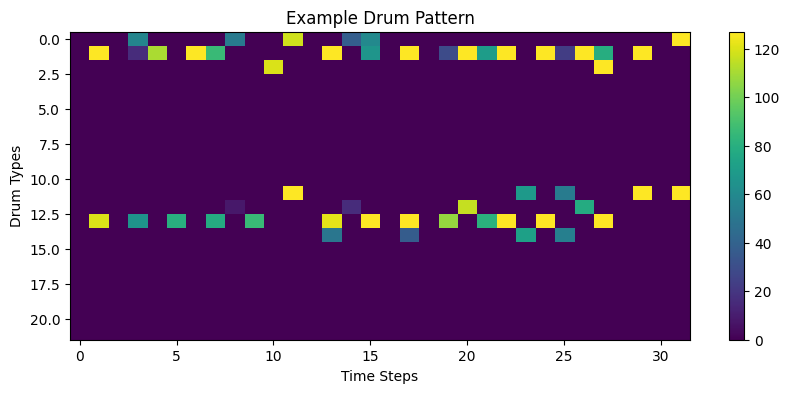

In [137]:


filepath_1 = target_files[1]
features, genre = extract_features_and_genre_from_filename(filepath_1)
print(f"Extracted features for {os.path.basename(filepath_1)} with genre {genre}")


segments = midi_file_to_segments(filepath_1)
print(f"Extracted {len(segments)} segments from {os.path.basename(filepath_1)}")
print("Example of one kick segment of 2 bars: \n",segments[1][0])
print("Example of one snare segment of 2 bars: \n",segments[1][1])
# Theres probably a lot of empty instruments like this one
print("Example of one ride bell segment of 2 bars: \n",segments[1][19])


def plot_drum_pattern(segment, title="Drum Pattern"):
    plt.figure(figsize=(10, 4))
    plt.imshow(segment, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Drum Types")
    plt.show()


if len(segments) > 0:
    plot_drum_pattern(segments[1].reshape(22, 32), title="Example Drum Pattern")


Create train/validation dataset

In [138]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Placeholder lists for features and labels
X_list = []
y_list = []


num_classes = len(genres)

# Looping over the dataset, extracting features and labels for each segment
for filepath in target_files:
    # Instead of extracting features for the whole file, extracting for each segment
    segments = midi_file_to_segments(filepath)  # Use segmentation function
    _, genre = extract_features_and_genre_from_filename(filepath)  # Extract genre
    
    if genre is not None:
        genre_index = genres.index(genre)
        for segment in segments:
            X_list.append(segment)
            y_list.append(to_categorical(genre_index, num_classes))
    else:
        print(f"Genre label not recognized for file {filepath}. Skipping.")

# Converting lists to numpy arrays for training
X = np.array(X_list)
# Making sure that X is reshaped correctly for CNN input
X = X.reshape((-1, len(relevant_notes), total_bins_per_segment, 1))

y = np.array(y_list)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)



(8601, 22, 32, 1)
(2151, 22, 32, 1)
(8601, 10)
(2151, 10)


# PCA and LDA
Here I have experimented with using a PCA layer, to reduce to the first 5 components, which then gets reduced further to 1 dimensions by the LDA filter. In constrast to drumclassifier_PCA_CNN, here the PCA filter is used on the whole 32 segment, instead of using a unique object on each timestep. Further the LDA is also used on the whole array, finding global patterns. To me, this means I loose the temporal pattern which I am/was interessted in exploring, but this model show much higher accuracy. 

In [139]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

def apply_pca_lda(X, y, num_pca_components, num_lda_components):
    num_samples, num_features, num_time_steps, _ = X.shape
    X_flat = X.reshape(num_samples * num_time_steps, num_features)

    # Apply scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)

    # Apply PCA
    pca = PCA(n_components=num_pca_components)
    X_pca = pca.fit_transform(X_scaled)

    # Apply LDA
    lda = LinearDiscriminantAnalysis(n_components=num_lda_components)
    X_lda = lda.fit_transform(X_pca, np.tile(y.argmax(axis=1), num_time_steps))

    # Reshape back for CNN input
    X_lda_reshaped = X_lda.reshape(num_samples, num_time_steps, num_lda_components, 1)

    return X_lda_reshaped, pca, lda, scaler

# Define the number of components for PCA and LDA
num_pca_components = 5  # Example: reduce to 5 principal components
num_lda_components = 1  # I want to end up with a single feature for the CNN
# Apply to training data
X_train_pca_lda, pca, lda, scaler = apply_pca_lda(X_train, y_train, num_pca_components, num_lda_components)

# Apply scaling, PCA and LDA transformation to validation data using fitted objects
X_val_flat = X_val.reshape(X_val.shape[0] * X_val.shape[2], X_val.shape[1])
X_val_scaled = scaler.transform(X_val_flat)
X_val_pca = pca.transform(X_val_scaled)
X_val_lda = lda.transform(X_val_pca)
X_val_lda_reshaped = X_val_lda.reshape(X_val.shape[0], X_val.shape[2], num_lda_components, 1)



# CNN
Using TensorFlow and Kera. 



In [140]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the CNN model
def create_pca_lda_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(32, 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dropout(0.6),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [141]:
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (X_train.shape[1], 1)  # (32, 1)
num_classes = len(genres)

# Create the model
model = create_pca_lda_cnn_model(input_shape, num_classes)

# Summary of the model
model.summary()


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_pca_lda, y_train, epochs=100, batch_size=32, validation_data=(X_val_lda_reshaped, y_val),callbacks=[early_stopping])

Model: "sequential_332"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_664 (Conv1D)         (None, 30, 32)            128       
                                                                 
 max_pooling1d_664 (MaxPool  (None, 15, 32)            0         
 ing1D)                                                          
                                                                 
 conv1d_665 (Conv1D)         (None, 13, 64)            6208      
                                                                 
 max_pooling1d_665 (MaxPool  (None, 6, 64)             0         
 ing1D)                                                          
                                                                 
 flatten_332 (Flatten)       (None, 384)               0         
                                                                 
 dropout_664 (Dropout)       (None, 384)            

# Save models

In [142]:
import joblib

# Save the entire CNN model
model.save('models/pca_lda_cnn/pca_lda_cnn_model_2G.keras') 
# Save the scaler, PCA, and LDA models
joblib.dump(scaler, 'models/pca_lda_cnn/scaler_2G.pkl')
joblib.dump(pca, 'models/pca_lda_cnn/pca_model_2G.pkl')
joblib.dump(lda, 'models/pca_lda_cnn/lda_model_2G.pkl')


['models/pca_lda_cnn/lda_model_2G.pkl']

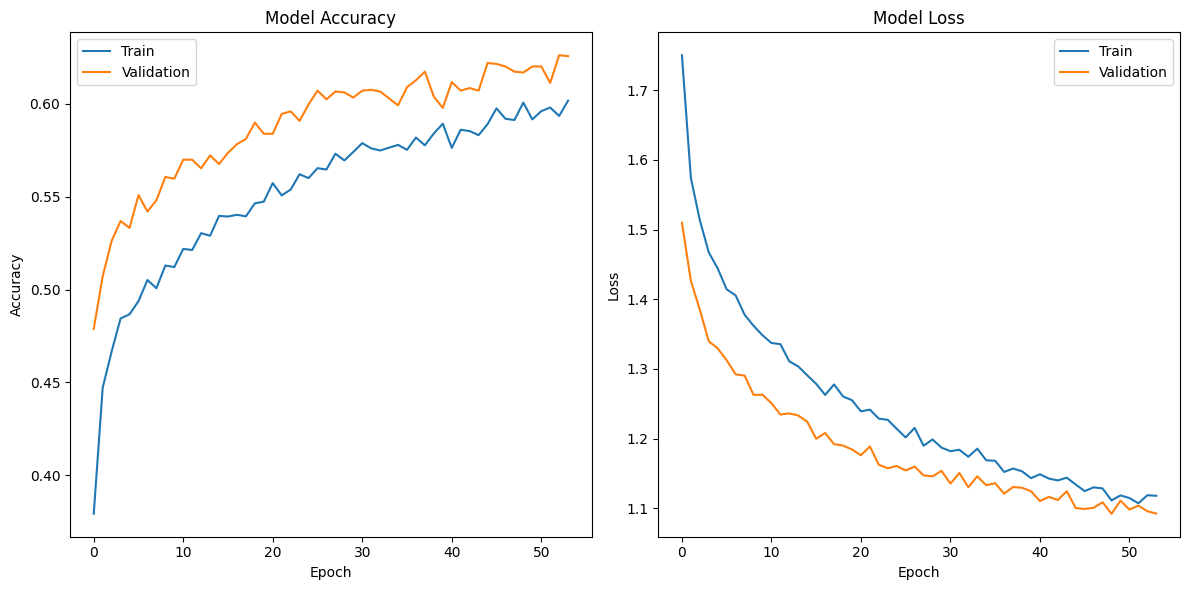

In [143]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


68/68 [==============================] - 0s 671us/step


/var/folders/kr/qv6lqld50753lntbp712rprm0000gn/T/ipykernel_58208/1686727357.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + class_labels)
/var/folders/kr/qv6lqld50753lntbp712rprm0000gn/T/ipykernel_58208/1686727357.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + class_labels)


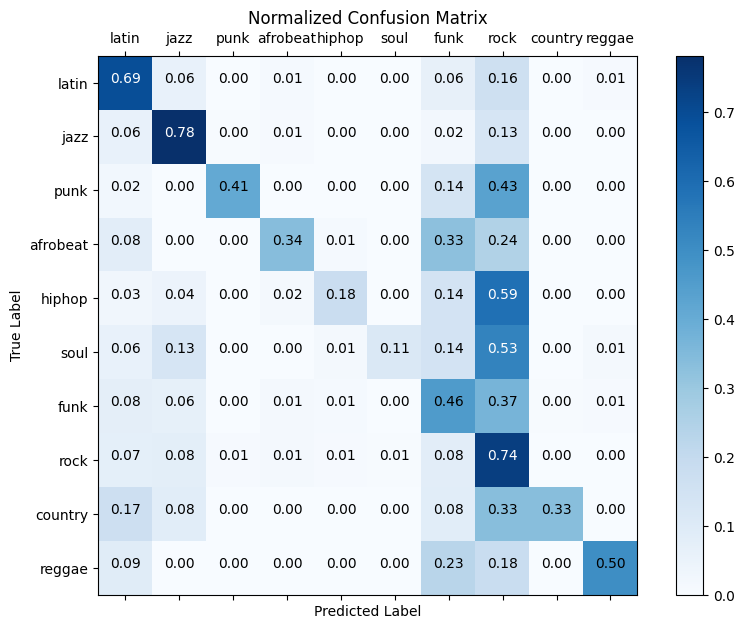

              precision    recall  f1-score   support

       latin       0.73      0.69      0.71       449
        jazz       0.67      0.78      0.72       316
        punk       0.72      0.41      0.52        44
    afrobeat       0.60      0.34      0.43        98
      hiphop       0.65      0.18      0.28       112
        soul       0.67      0.11      0.20        70
        funk       0.45      0.46      0.45       293
        rock       0.59      0.74      0.65       735
     country       0.80      0.33      0.47        12
      reggae       0.58      0.50      0.54        22

    accuracy                           0.62      2151
   macro avg       0.65      0.45      0.50      2151
weighted avg       0.62      0.62      0.60      2151



In [144]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predicting the validation set
predictions = model.predict(X_val_lda_reshaped)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Normalizing the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))
cax = ax.matshow(cm_normalized, cmap=plt.get_cmap('Blues'))
fig.colorbar(cax)

# Set labels to be more informative
class_labels = genres  
ax.set_xticklabels([''] + class_labels)
ax.set_yticklabels([''] + class_labels)

# Major ticks location
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

# Labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')

# Add annotations to cells
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > 0.5 else "black")

plt.show()


print(classification_report(true_classes, predicted_classes, target_names=class_labels))


# K-Fold

In [145]:
from sklearn.model_selection import RepeatedKFold

# Define parameters
n_splits = 10  # Number of folds
n_repeats = 5  # Number of repetitions
random_state = 42  # Ensures reproducibility

# Initialize RepeatedKFold
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

def evaluate_model(X, y, rkf):
    scores = []
    for train_index, test_index in rkf.split(X):
        # Split data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Apply PCA and LDA
        X_train_transformed, pca, lda, scaler = apply_pca_lda(X_train, y_train, num_pca_components, num_lda_components)
        X_test_flat = X_test.reshape(X_test.shape[0] * X_test.shape[2], X_test.shape[1])
        X_test_scaled = scaler.transform(X_test_flat)
        X_test_pca = pca.transform(X_test_scaled)
        X_test_lda = lda.transform(X_test_pca)
        X_test_lda_reshaped = X_test_lda.reshape(X_test.shape[0], X_test.shape[2], num_lda_components, 1)

        # Define the model 
        model = create_pca_lda_cnn_model((X_train_transformed.shape[1], X_train_transformed.shape[2]), y_train.shape[1])

        # Compile and train the model
        history = model.fit(X_train_transformed, y_train, verbose=0, epochs=100, batch_size=32, validation_data=(X_test_lda_reshaped, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

        # Evaluate the model
        score = model.evaluate(X_test_lda_reshaped, y_test, verbose=0)
        scores.append(score)
        print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

    return scores


scores = evaluate_model(X, y, rkf)
average_score = np.mean([score[1] for score in scores])
print(f'Mean accuracy across all folds and repeats: {average_score}')


Test loss: 1.0908609628677368, Test accuracy: 0.6189591288566589
Test loss: 1.0768647193908691, Test accuracy: 0.6375464797019958
Test loss: 1.0961765050888062, Test accuracy: 0.620465099811554
Test loss: 1.1448452472686768, Test accuracy: 0.5953488349914551
Test loss: 1.0936411619186401, Test accuracy: 0.6148837208747864
Test loss: 1.0471982955932617, Test accuracy: 0.626976728439331
Test loss: 1.0210903882980347, Test accuracy: 0.6399999856948853
Test loss: 1.0883212089538574, Test accuracy: 0.626976728439331
Test loss: 1.149969458580017, Test accuracy: 0.604651153087616
Test loss: 1.1890815496444702, Test accuracy: 0.577674388885498
Test loss: 1.0752369165420532, Test accuracy: 0.6115241646766663
Test loss: 1.0683164596557617, Test accuracy: 0.6310408711433411
Test loss: 1.1525371074676514, Test accuracy: 0.5962790846824646
Test loss: 1.1115423440933228, Test accuracy: 0.6186046600341797
Test loss: 1.122601866722107, Test accuracy: 0.6148837208747864
Test loss: 1.102854609489441, Te